# Marketplace Metrics Improvement Analysis

## Introduction

This project examines “NovoMercado,” a Brazilian online marketplace dedicated to the sale of new products. The analysis centers on understanding customer purchasing patterns and identifying areas for operational improvement to enhance overall customer satisfaction and business performance. 

The comprehensive dataset includes transactions from the marketplace’s inception, providing a robust foundation for trend analysis and strategic planning.

## Goal

The primary objective of this project is to enhance customer retention and streamline order processing at NovoMercado. By analyzing transactional data, the project aims to pinpoint the root causes of order cancellations and delays, thereby proposing actionable solutions to boost overall customer engagement and repeat purchases.

## Objectives

The key objectives of this project are:
1. **Assess Monthly Retention**: Evaluate monthly retention through cohort analysis to understand customer loyalty and the recurrence of purchases.
2. **Determine Product-market fit**: Identify whether the product meets the market demand effectively and pinpoint areas for enhancement.
3. **Identify Key Metrics**: Determine five principal metrics that the product should focus on to maximize company profitability.
4. **Prioritize Hypotheses with ICE Framework**: Select one of the top three hypotheses using the ICE framework to guide significant improvements in the product.
5. **Formulate Impactful Metrics**: Develop metrics that reflect the influence of the chosen hypothesis on the marketplace’s performance.
6. **Conclude with Insights**: Summarize findings from the analysis to provide actionable insights and recommendations.

## Data description

The analysis in this project utilizes data derived from three main CSV files, reflecting different facets of user activity and order processing within the Brazilian Marketplace:
1. **olist_customers_dataset.csv** - Contains unique identifiers for customers:
    - customer_id: Identifier for the customer (akin to a transaction ID).
    - customer_unique_id: Unique customer identifier (analogous to a passport number).
    - customer_zip_code_prefix: Postal code of the customer.
    - customer_city: Delivery city of the customer.
    - customer_state: Delivery state of the customer.

2. **olist_orders_dataset.csv** - Records the details of orders placed:
    - order_id: Unique order identifier.
    - customer_id: Links to the customer’s identifier.
    - order_status: Status of the order (e.g., delivered, canceled).
    - order_purchase_timestamp: Timestamp of the order placement.
    - order_approved_at: Timestamp of payment approval.
    - order_delivered_carrier_date: Timestamp when the order was handed over to the logistics carrier.
    - order_delivered_customer_date: Timestamp when the order was delivered to the customer.
    - order_estimated_delivery_date: Expected date of delivery.

3. **olist_order_items_dataset.csv** - Details the items included in each order:
    - order_id: Corresponds to the unique identifier for each order.
    - order_item_id: Identifier for individual items within an order.
    - product_id: ID of the product.
    - seller_id: ID of the product’s seller.
    - shipping_limit_date: The maximum date for shipping the product to maintain schedule.
    - price: Price of each unit of the product.
    - freight_value: Shipping cost associated with the product.

**Order status explanation**
- created: Order has been placed but not processed.
- approved: Payment has been approved.
- invoiced: Invoice has been issued.
- processing: Order is being prepared.
- shipped: Order has been sent from the warehouse.
- delivered: Order has reached the customer.
- unavailable: Order canceled due to unavailability of stock.
- canceled: Order canceled by the customer or the system.

## Libraries used

The following libraries are used throughout this project for data processing and visualization.

In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
from operator import attrgetter
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors

---

## Analyzing monthly retention for order processing

**Process description**

In this initial phase, I delved into understanding the monthly retention rate as an essential metric for evaluating customer return rates and purchasing behaviors on the marketplace. Key steps included:

1. **Data examination and order type definition**: I reviewed three datasets to understand the data structure and identified relevant order types (e.g., ‘delivered’) that should be considered in the retention analysis.

2. **Retention calculation and analysis**: I calculated monthly retention to visualize customer return patterns and determined the median retention rate for the first month post-initial purchase. This analysis helped pinpoint high-retention customer cohorts, providing insights into engaged segments crucial for strategic decision-making.

In [116]:
customers = pd.read_csv('data/olist_customers_dataset.csv')

In [117]:
customers.shape

(99441, 5)

In [118]:
orders = pd.read_csv('data/olist_orders_dataset.csv')

In [119]:
orders.shape

(99441, 8)

In [120]:
order_items = pd.read_csv('data/olist_order_items_dataset.csv')

In [121]:
order_items.shape

(112650, 7)

In [122]:
# Merging only the first two DataFrames, as the third one isn’t needed yet.

customers_and_orders = pd.merge(customers, orders, on='customer_id')

In [123]:
customers_and_orders.shape

(99441, 12)

In [124]:
customers_and_orders.dtypes

customer_id                      object
customer_unique_id               object
customer_zip_code_prefix          int64
customer_city                    object
customer_state                   object
order_id                         object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [125]:
# For ease of working with dates, it’s necessary to convert the format from Object to Datetime.

customers_and_orders['order_purchase_timestamp'] = pd.to_datetime(customers_and_orders['order_purchase_timestamp'])

In [126]:
# Retaining only the relevant type of orders, i.e., those that are delivered.

customers_and_orders.query('order_status == "delivered"', inplace=True)

In [127]:
customers_and_orders.shape

(96478, 12)

In [128]:
# For implementing cohort analysis, only two columns are necessary. I’m retaining only those.

customers_and_purchases = customers_and_orders[['customer_unique_id', 'order_purchase_timestamp']]

In [129]:
# For secure operations, I’m processing the table based on a copy.

customers_and_purchases_copy = customers_and_purchases.copy()

In [130]:
# Extracting the month and day of the order.

customers_and_purchases_copy['order_period'] = customers_and_purchases_copy['order_purchase_timestamp'].dt.to_period('M')
customers_and_purchases_copy['order_period_day'] = customers_and_purchases_copy['order_purchase_timestamp'].dt.to_period('D')

In [131]:
# Assigning cohorts based on the date of first action for each user.

customers_and_purchases_copy['cohort'] = customers_and_purchases_copy \
    .groupby('customer_unique_id') \
    ['order_purchase_timestamp'].transform('min') \
    .dt.to_period('M')

customers_and_purchases_copy['cohort_day'] = customers_and_purchases_copy \
    .groupby('customer_unique_id') \
    ['order_purchase_timestamp'].transform('min') \
    .dt.to_period('D')

In [132]:
# Calculating the period number in days (using monthly periods, dividing by 30).

customers_and_purchases_copy['period_number_month'] = np.floor((customers_and_purchases_copy.order_period_day - customers_and_purchases_copy.cohort_day).apply(attrgetter('n')) / 30)

In [133]:
# Aggregating data by cohorts and the calculated period number (in months).

cohorts = customers_and_purchases_copy \
    .groupby(['cohort', 'period_number_month']) \
    .agg(n_customers=('customer_unique_id', 'nunique')).reset_index()

In [134]:
cohorts.shape

(215, 3)

In [135]:
# Creating a pivot table for cohort analysis.

cohorts_pivot = cohorts.pivot_table(index='cohort', columns='period_number_month', values='n_customers')

In [136]:
# Calculating cohort sizes (the first column of the pivot table).

cohorts_size = cohorts_pivot.iloc[:, 0]

In [137]:
# Calculating retention rates by dividing by the cohort size.

retention_matrix = cohorts_pivot.divide(cohorts_size, axis=0)

In [138]:
# The median retention rate among all cohorts in the first month is very low.

median_retention_first_month = round(retention_matrix[1.0].median(), 4)
median_retention_first_month

0.0035

In [139]:
# Identifying the cohort with the highest retention in the third month.

max_third_month_retention = retention_matrix[3.0].max()
cohort_with_max_retention = retention_matrix[retention_matrix[3.0] == max_third_month_retention].index[0]
cohort_with_max_retention

Period('2017-01', 'M')

---

## Assessing Product-market fit

**Process Description**

In this task, I evaluated whether the marketplace product effectively met the needs of its customers. The focus was on determining the presence of a Product-market fit, which is crucial for strategic decision-making regarding product adaptation or market expansion. The steps I took included:

1. **Evaluating the presence of Product-market fit**: Using previously calculated retention rates, I assessed how well the product satisfied customer requirements, which indicated the strength of the Product-market fit.

2. **Articulating the position and formulating a strategy**: Based on the presence of a strong Product-market fit, I outlined strategic initiatives the marketplace should focus on in the near term to enhance or leverage this fit. If the Product-market fit was lacking, I explored potential reasons and suggested areas for improvement.

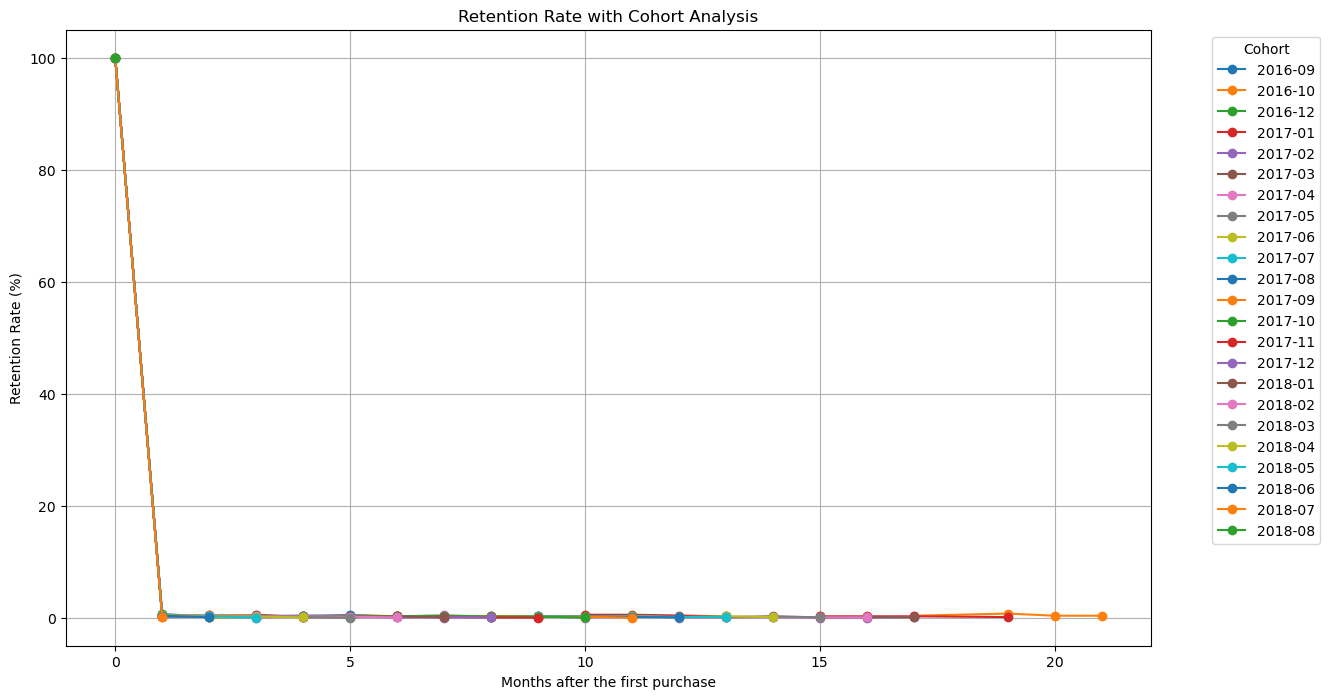

In [140]:
# Converting retention from fractions to percentages.

retention_percentages = retention_matrix * 100

# Building the graph.

plt.figure(figsize=(14, 8))
for cohorts, data in retention_percentages.iterrows():
    plt.plot(data.index, data.values, marker='o', label=str(cohorts))

plt.title('Retention Rate with Cohort Analysis')
plt.xlabel('Months after the first purchase')
plt.ylabel('Retention Rate (%)')
plt.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

**Key findings and recommendations**

Based on the conducted cohort analysis, it can be established that Product-market fit (PMF) is absent in this Marketplace. This is reflected in the low level of retention, which indicates that the product does not fully meet the needs and expectations of the target audience.

The retention rate in the first month after purchase is a critical indicator for assessing PMF, as it demonstrates users’ willingness to reuse the product. Ideally, for PMF to exist, there should be a sufficiently high return in the first month followed by a slow decline or stabilization at a certain level.

The reasons for weak user retention could be:

1. **Product mismatch with customer expectations**: Users may not find unique value in the Marketplace offerings, which does not motivate them for repeat purchases.
2. **Limited selection of goods or services**: If the assortment on the platform is limited or does not meet current market trends or needs, users may switch to competitors.
3. **Issues with user experience**: Difficulties with site navigation, lengthy order processing, insufficiently convenient payment or delivery methods can repel users.
4. **Lack of an effective customer retention strategy**: Inadequate efforts in engaging customers, such as the absence of personalized offers, loyalty programs, or targeted marketing impacts.
5. **Technical issues and bugs**: Instability of the platform, frequent failures or errors can lead to a loss of trust among users.

To increase retention and potentially achieve PMF, the Marketplace should focus on improving the quality of service and product, researching the needs of its audience, and developing more personalized and targeted marketing strategies. This will help create deeper and more meaningful relationships with customers, ultimately facilitating repeat purchases and sustainable growth.

---

## Define key metrics for maximizing company profits

**Process description**

To better align our strategic focus and drive profitability, it’s essential to identify and track the right metrics that will guide our decision-making process. The chosen metrics should reflect crucial aspects of our business operations and directly impact our bottom line. Here’s how I addressed the task:

**Identifying the metrics**:

1. **Growth metric**: This metric tracks the growth in overall sales volume, indicating the marketplace’s expansion and success in attracting transactions.
2. **Audience size metric**: It measures the size of the active user base, which the product successfully retains and serves, providing a clear picture of our market reach.
3. **New client interest metric**: This reflects the interest of new clients in our services, gauging our success in attracting fresh market segments.
4. **Client engagement metric**: Indicates the depth of client engagement with our platform, assessing how frequently and intensely users interact with our services.
5. **Financial involvement metric**: Shows the monetary commitment of the clients, which helps in understanding their spending behavior and the financial health of our transactions.

**Justification and utilization**: Each metric was selected for its direct impact on the company’s revenue and strategic goals. By monitoring these metrics, we can pinpoint areas needing improvement or potential for further growth, ensuring that our marketplace remains competitive and responsive to market demands. This approach helps in refining our operations and boosting overall profitability.

### 1. Growth metric

In [141]:
# Merging all three DataFrames to create a comprehensive dataset for further analysis.

merged_df = pd.merge(customers, orders, on='customer_id')
merged_df = pd.merge(merged_df, order_items, on='order_id')

In [142]:
merged_df.shape

(112650, 18)

In [143]:
# Ensuring that the date column is in the correct format.

merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])

In [144]:
# Grouping data by month and summing the order costs.

monthly_sales = merged_df \
    .groupby(merged_df['order_purchase_timestamp'].dt.to_period('M')) \
    .agg({'price': 'sum'}) \
    .rename(columns={'price': 'revenue'}) \
    .rename_axis('month') \
    .reset_index()

In [145]:
# Converting the period to a date format for easier graph plotting.

monthly_sales['month'] = monthly_sales['month'].dt.to_timestamp()

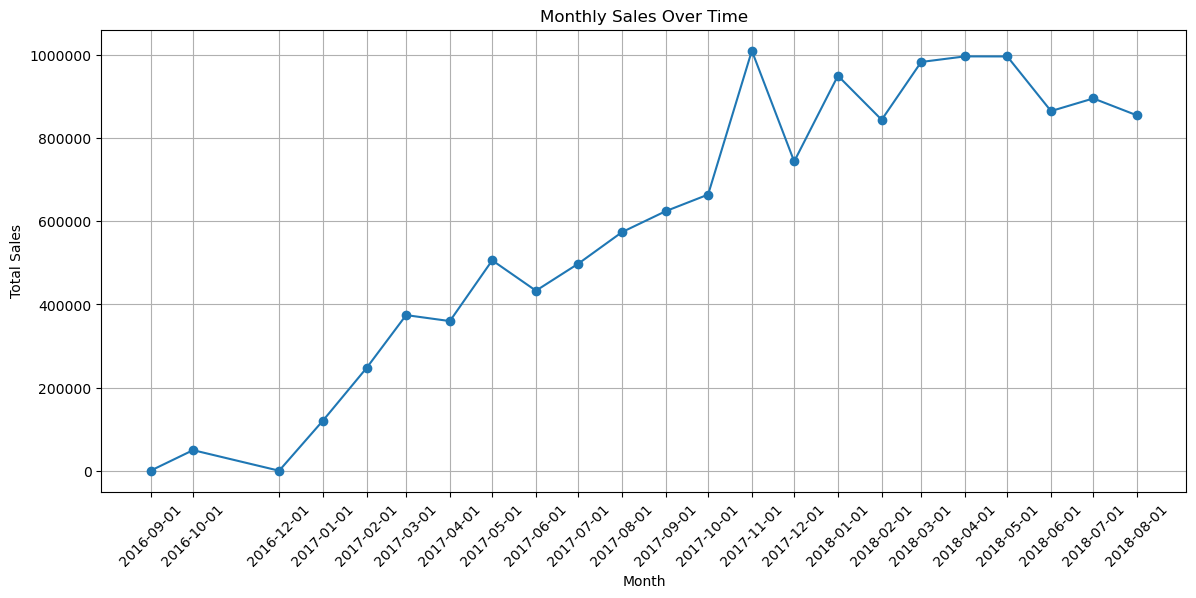

In [146]:
# Deleting the last month, as we don't have the data.

monthly_sales_trimmed = monthly_sales.iloc[:-1]

# Building the graph.

plt.figure(figsize=(14, 6))
plt.plot(monthly_sales_trimmed['month'], monthly_sales_trimmed['revenue'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.xticks(monthly_sales_trimmed['month'], rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

### 2. Audience size metric

In [147]:
# Here, the MAU metric fits perfectly, so I’m grouping data by month and retaining only unique users.

mau = merged_df \
    .groupby(merged_df['order_purchase_timestamp'].dt.to_period('M')) \
    ['customer_unique_id'].nunique() \
    .reset_index()

# Renaming columns for clarity.
mau.columns = ['month', 'monthly_active_users']

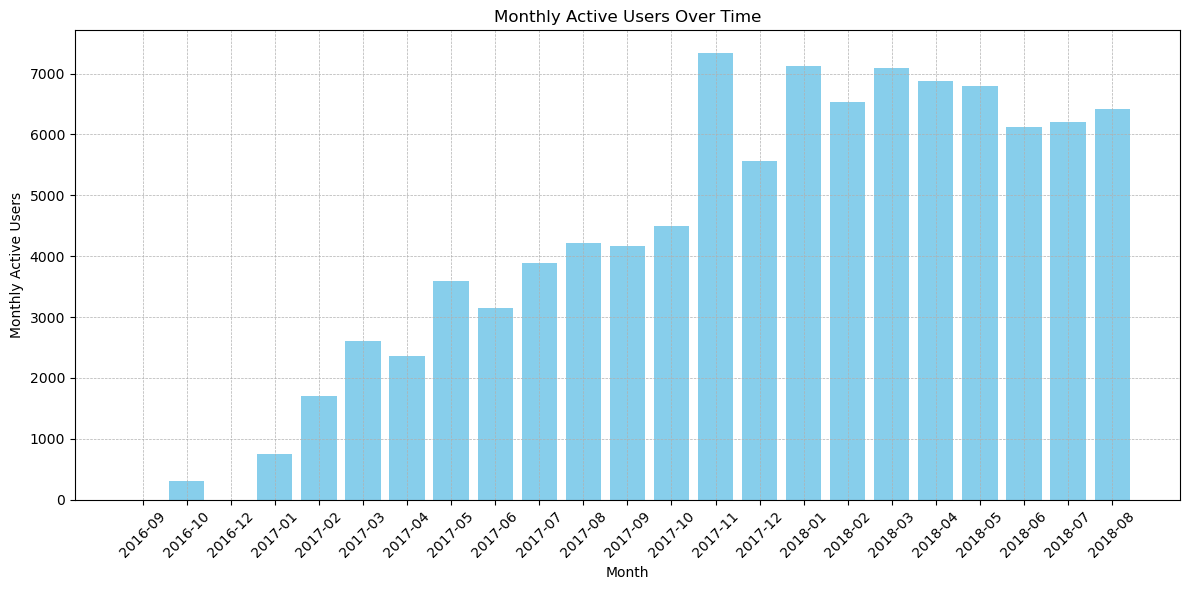

In [148]:
# Deleting the last month, as we don't have the data.

mau_trimmed = mau.iloc[:-1]

# Building the graph.

plt.figure(figsize=(12, 6))
plt.bar(mau_trimmed['month'].astype(str), mau_trimmed['monthly_active_users'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Monthly Active Users')
plt.title('Monthly Active Users Over Time')
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout() 
plt.show()

## 3. New client interest metric

In [149]:
# Ensuring the dates are in the correct format.

merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])

# Finding the first purchase date for each user.

first_purchase = merged_df.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index()
first_purchase.columns = ['customer_unique_id', 'first_purchase_date']

In [150]:

# Adding the first purchase date to the main DataFrame.

merged_df = merged_df.merge(first_purchase, on='customer_unique_id', how='left')

# Counting the number of new users per month.
first_purchase['cohort_month'] = first_purchase['first_purchase_date'].dt.to_period('M')
new_users_by_month = first_purchase.groupby('cohort_month')['customer_unique_id'].nunique().reset_index()
new_users_by_month.columns = ['month', 'total_new_users']

In [151]:
# Counting the number of new users who made at least one purchase.
# In our case, all new users already made a purchase, so the conversion rate = 100%.
# If we only need active ones, we can add a filter by order status.

paying_users = merged_df.query('order_status == "delivered"') \
    .drop_duplicates(subset='customer_unique_id') \
    .copy()
paying_users['month'] = paying_users['first_purchase_date'].dt.to_period('M')

paying_users_by_month = paying_users.groupby('month')['customer_unique_id'].nunique().reset_index()
paying_users_by_month.columns = ['month', 'paying_users']

In [152]:
# Merge the two DataFrames.

conversion_df = new_users_by_month.merge(paying_users_by_month, on='month', how='left')
conversion_df['conversion_rate'] = conversion_df['paying_users'] / conversion_df['total_new_users']
conversion_df['conversion_rate'] = conversion_df['conversion_rate'].fillna(0)

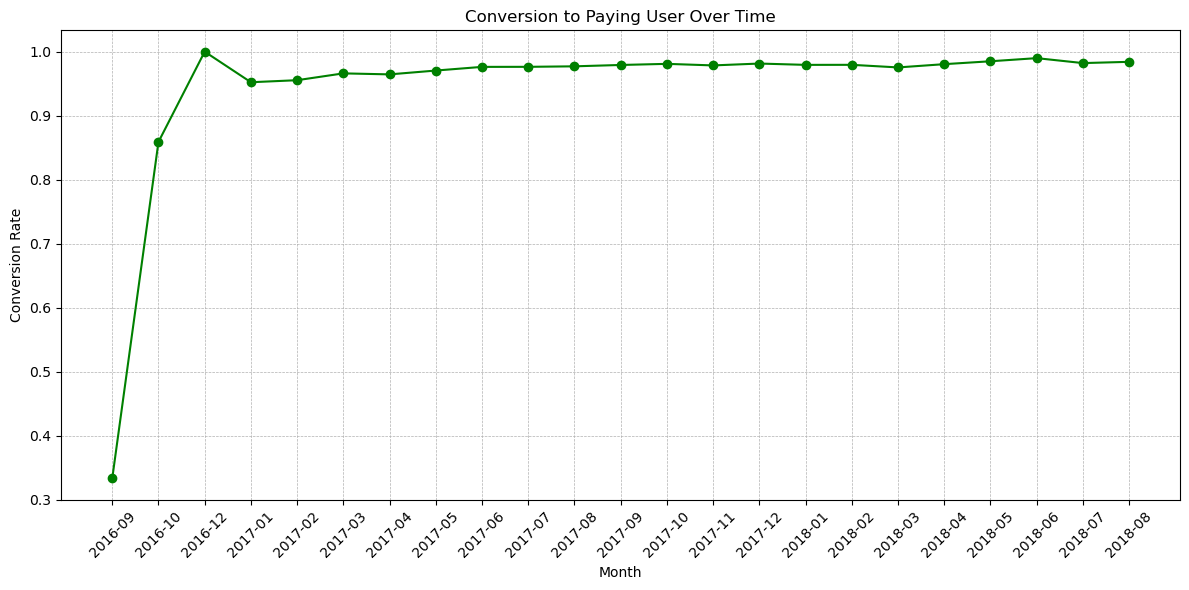

In [153]:
# Building the graph.

plt.figure(figsize=(12, 6))
plt.plot(conversion_df['month'].astype(str), conversion_df['conversion_rate'], marker='o', color='green')
plt.title('Conversion to Paying User Over Time')
plt.xlabel('Month')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### 4. Client engagement metric

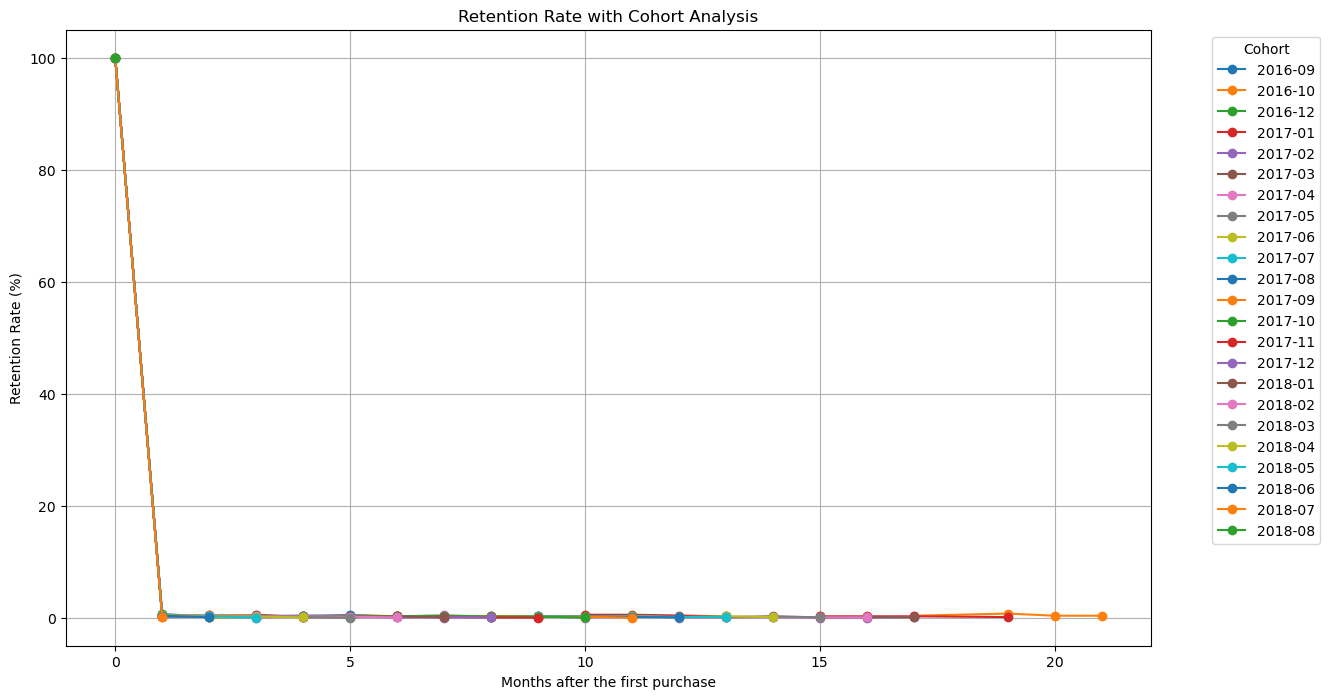

In [154]:
# I am measuring customer engagement in continued use of the Marketplace using the same Retention graph.
# Once again, it is important to note that the Retention rate remains very low.

plt.figure(figsize=(14, 8))
for cohorts, data in retention_percentages.iterrows():
    plt.plot(data.index, data.values, marker='o', label=str(cohorts))

plt.title('Retention Rate with Cohort Analysis')
plt.xlabel('Months after the first purchase')
plt.ylabel('Retention Rate (%)')
plt.legend(title='Cohort', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

## 5 Financial involvement metric

In [155]:
filtered_df = merged_df.query('order_status == "delivered"').copy()

filtered_df['order_purchase_timestamp'] = pd.to_datetime(filtered_df['order_purchase_timestamp'])

# Grouping the data by month and customer ID and calculating the revenue generated by each customer.

user_engagement = filtered_df \
    .groupby([filtered_df['order_purchase_timestamp'].dt.to_period('M'), 'customer_unique_id']) \
    ['price'].sum() \
    .reset_index()

user_engagement.columns = ['month', 'customer_unique_id', 'revenue']

# Сalculating the average revenue per user (ARPU) by month.

monthly_average_revenue_per_user = user_engagement.groupby('month')['revenue'].mean().reset_index()

In [156]:
# Converting the period to a date format for easier graph plotting.

monthly_average_revenue_per_user['month'] = monthly_average_revenue_per_user['month'].dt.to_timestamp()

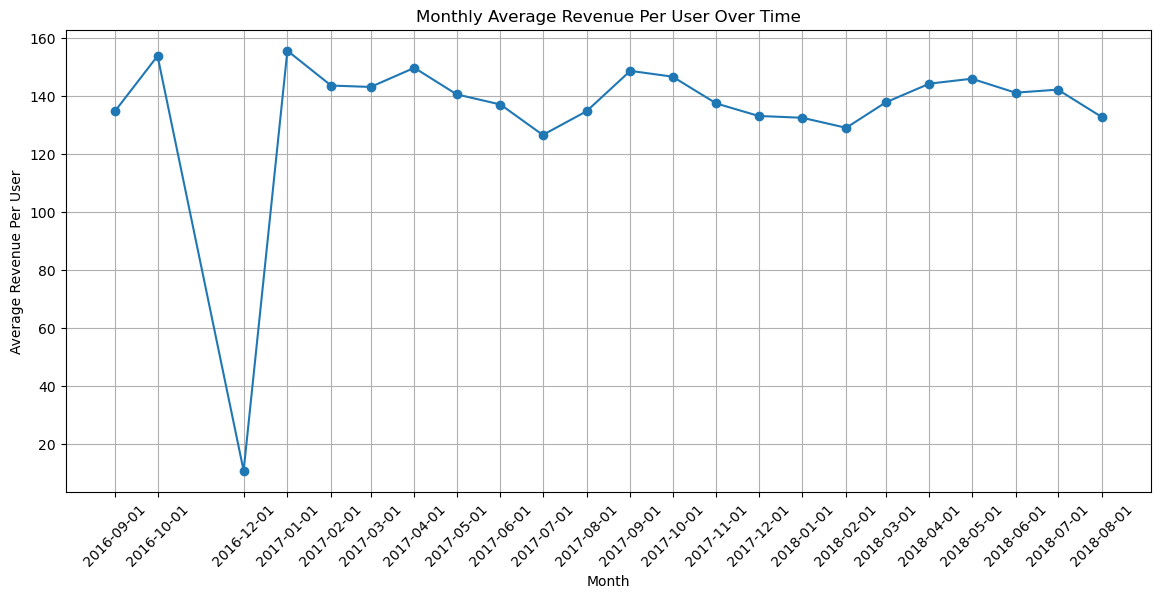

In [157]:
# Building the graph.

plt.figure(figsize=(14, 6))
plt.plot(monthly_average_revenue_per_user['month'], monthly_average_revenue_per_user['revenue'], marker='o')
plt.title('Monthly Average Revenue Per User Over Time')
plt.xlabel('Month')
plt.ylabel('Average Revenue Per User')
plt.grid(True)
plt.xticks(monthly_average_revenue_per_user['month'], rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

---

## Selecting the most impactful hypothesis using the ICE framework

**Process Description**

To determine which product change would bring the most value to the marketplace, I applied the ICE framework (Impact, Confidence, Ease) to three product hypotheses. This framework allows teams to prioritize ideas based on their potential value, feasibility, and certainty — especially when multiple directions are possible.

Impact was calculated using product data, while Confidence and Ease were evaluated based on subjective yet reasoned assumptions, taking into account the complexity of implementation and the team’s certainty in the results. These values are necessary for calculating the final ICE score as the average of the three components:

$$\text{ICE score} = Impact * Confidence * Ease$$

To quantify Impact, I used a scoring scale derived from the potential number of additional successful transactions or returning users that could be expected if the hypothesis were implemented. The scale converts the raw metric into a 1–10 score as shown below:

| Impact | Metric Range      |
|--------------|-------------------|
| 1            | 0 – 50            |
| 2            | 51 – 150          |
| 3            | 151 – 350         |
| 4            | 351 – 750         |
| 5            | 751 – 1550        |
| 6            | 1551 – 3150       |
| 7            | 3151 – 6350       |
| 8            | 6351 – 12750      |
| 9            | 12751 – 25550     |
| 10           | 25551 – 51150     |

**Hypothesis 1**

If we fix a bug in the order processing system, customers will no longer face issues with order cancellations, which will lead to an increase in the number of delivered orders.

**Hypothesis 2**

If we reduce the time before the order is shipped, customers will stop receiving their orders with delays, which will increase the number of orders due to more repeat purchases.

**Hypothesis 3**

If we introduce a new payment method that encourages customers to place repeat orders, they will face fewer difficulties during checkout, which will increase the number of orders through improved retention.

In [158]:
# To avoid skewed historical patterns, I used data from June 2017 onward, focusing on a more stable period of the marketplace’s operations.

orders_from_june_2017 = orders[orders.order_purchase_timestamp >= '2017-06'].copy()

In [159]:
# For simplicity, we use the median first-month retention rate (identified during cohort analysis) as a proxy when calculating Impact for those hypotheses where conversion to a repeat purchase is relevant.

retention = round(retention_matrix[1.0].median(), 4)
retention

0.0035

### Calculating the Impact score of the hypothesis 1

In [160]:
# To calculate the Impact score for this hypothesis, I counting the number of orders with the statuses “canceled” and “unavailable”.

orders_status_groups = orders_from_june_2017.groupby('order_status').order_id.nunique()
number_of_canceled_orders = orders_status_groups.canceled + orders_status_groups.unavailable

impact_score_hypothesis_1 = number_of_canceled_orders
print(f"Impact score of the first hypothesis: {round(impact_score_hypothesis_1)} orders")

Impact score of the first hypothesis: 974 orders


### Calculating the Impact score of the hypothesis 2

In [161]:
# I determine the number of orders that were delivered with a delay.

orders_from_june_2017['order_estimated_delivery_date'] = pd.to_datetime(orders_from_june_2017['order_estimated_delivery_date'])
orders_from_june_2017['order_delivered_customer_date'] = pd.to_datetime(orders_from_june_2017['order_delivered_customer_date'])

orders_from_june_2017['order_estimated_day'] = orders_from_june_2017['order_estimated_delivery_date'].dt.to_period('D')
orders_from_june_2017['order_delivery_day'] = orders_from_june_2017['order_delivered_customer_date'].dt.to_period('D')

In [162]:
number_of_delayed_orders = orders_from_june_2017[(orders_from_june_2017.order_delivery_day > orders_from_june_2017.order_estimated_day)
    & (orders_from_june_2017.order_status.isin(['delivered']))] \
    .order_id.nunique()

number_of_delayed_orders

6087

In [163]:
impact_score_hypothesis_2 = number_of_delayed_orders * retention
print(f"Impact score of the second hypothesis: {round(impact_score_hypothesis_2)} orders")

Impact score of the second hypothesis: 21 orders


### Calculating the Impact score of the hypothesis 3

In [164]:
# To determine the Impact score for this hypothesis, I counting the number of customers who made only one purchase and multiply it by the retention rate. 
# This will help estimate the number of repeat purchases that could have occurred.

# Counting the number of orders for each customer.

delivered_orders = orders[(orders['order_status'] == 'delivered')]

delivered_orders_and_customers = delivered_orders.merge(customers[['customer_id', 'customer_unique_id']],
                                                 on='customer_id',
                                                 how='left')


numbers_of_orders_by_customers = delivered_orders_and_customers[(delivered_orders_and_customers.order_purchase_timestamp >= '2017-06')].groupby('customer_unique_id').order_id.nunique().reset_index()

In [165]:
# Counting the number of customers who made only one purchase.

customers_made_only_purchase = (numbers_of_orders_by_customers == 1).order_id.sum()
print(f'Number of customers who made only one purchase: {customers_made_only_purchase}')

Number of customers who made only one purchase: 80558


In [166]:
impact_score_hypothesis_3 = customers_made_only_purchase * retention
print(f"Impact score of the third hypothesis: {round(impact_score_hypothesis_3)} orders")

Impact score of the third hypothesis: 282 orders


### ICE counting

| Hypothesis | Impact (score) | Impact | Confidence | Ease | ICE |
|-----------|---------------|----------------|------------|------|-----------|
| Fix order processing bug to prevent cancellations | 974 orders | 5 | 8 | 6 | **240** |
| Reduce delivery delay to encourage repeat purchases | 21 orders | 2 | 10 | 4 | **80** |
| Add new payment method to ease repeat purchases | 282 orders | 3 | 5 | 9 | **135** |

According to the final ICE scores, the **first hypothesis** should be prioritized, as it shows the highest expected impact and feasibility among the proposed improvements.

---

## Formulating relevant metrics based on the selected hypothesis

After the previous analysis, we formulated a hypothesis that can potentially lead to a significant improvement in the company's performance indicators. This hypothesis can be tested using A/B testing to evaluate its effectiveness.

Based on the selected hypothesis — **fixing the bug in the order processing system to reduce order cancellations** — the following metrics are proposed as key areas for improvement.

#### Impact Metrics:
1. **Increase in the number of delivered orders** – A quantitative measure of the growth in successfully delivered orders compared to previous periods.
2. **Increase in total revenue** – Growth in total sales revenue, reflecting an increase in the number of successful transactions on the platform.

#### Proxy Metrics:
1. **Reduction in the percentage of canceled orders** – A metric showing the percentage change in the number of canceled orders after the bug fix.
2. **Increase in average revenue per user** – A change in the average order value, which may indicate increased customer trust and satisfaction.

#### Guardrail Metrics:
1. **Customer satisfaction** – A change in customer satisfaction indicators measured through surveys or feedback systems.
2. **Repeat purchase frequency** – Changes in the frequency of repeat purchases, which may reflect increased customer loyalty due to improved service quality.

---

# Summary

This project presents a comprehensive analysis of customer behavior on a Brazilian online marketplace. Using cohort analysis, retention metrics, and user segmentation, I evaluated the product’s performance in terms of customer engagement and repeat usage. The analysis revealed a lack of Product-market fit, indicated by low retention rates. Based on the insights, I formulated data-driven hypotheses, prioritized them using the ICE framework, and identified key metrics for improvement. 

This groundwork sets the foundation for an A/B test to validate the most impactful hypothesis aimed at reducing order cancellations and improving overall platform performance.